

#Quantization-Aware Finetuning YoloNAS on a Custom Dataset



**Background**: Se trata de una nueva arquitectura de aprendizaje profundo que compite con YOLOv8 utilizando nuestro eficiente algoritmo AutoNAC. El nuevo modelo, llamado YoloNAS, incorpora bloques RepVGG compatibles con cuantización en su arquitectura para garantizar la compatibilidad con la cuantización posterior al entrenamiento. Esto lo hace más flexible y adaptable a diferentes configuraciones de hardware


Trabajamos el dataset etiquetado obtenido de https://universe.roboflow.com/gpcc-c2oqa/placasvwise/dataset/31

Es importante aclarar que ya se encuentra etiquetado, los pasos fueron los siguientes:

0. Installations and dataset setup.
1. Initialize train and validation dataloaders.
2. Define training hyper-parameters.
3. Instantiate a pre-trained YoloNAS_S model and launch training.
4. Run prediction on a real world input.
5. Load the best checkpoint from 3., perform post-training quantization and quantization-aware training.
Pasos del proceso:

**Instalaciones y configuración del conjunto de datos**: Prepara el entorno instalando las librerías necesarias y configurando el conjunto de datos que se usará para entrenar el modelo.

**Inicialización de dataloaders para entrenamiento y validación**: Define dos dataloaders, uno para el entrenamiento del modelo y otro para la validación. Estos cargadores se encargarán de leer y procesar las imágenes del conjunto de datos de forma eficiente.

**Definición de hiperparámetros de entrenamiento**: Establece los parámetros que controlarán el proceso de entrenamiento, como la tasa de aprendizaje, el número de épocas, etc. Estos parámetros son cruciales para lograr un buen rendimiento del modelo.

**Creación de un modelo YoloNAS_S pre-entrenado e inicio del entrenamiento:** Se carga una versión pre-entrenada del modelo YoloNAS_S y se inicia el entrenamiento utilizando los parámetros definidos en el paso anterior.

**Predicción en una entrada:** Una vez entrenado el modelo, se utiliza para realizar predicciones sobre una imagen real (una imagen que no pertenece al conjunto de datos de entrenamiento).






## Step 0: Dataset Setup

DESCARGA DE DATASET


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="kYdwX5G2R2CyqEU3CQdh")
project = rf.workspace("gpcc-c2oqa").project("placasvwise")
version = project.version(31)
dataset = version.download("yolov8")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to placasvwise-31 in yolov8:: 100%|██████████| 16872/16872 [00:07<00:00, 2334.11it/s]


# Instalaciones

Comenzamos con obtener torch, super-gradients y verificando nuestra GPU

In [ ]:
! pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113 &> /dev/null
! pip install pytorch-quantization==2.1.2 --extra-index-url https://pypi.ngc.nvidia.com &> /dev/null
! pip install super-gradients==3.2.0
! pip show super_gradients
# ! pip install git+https://github.com/Deci-AI/super-gradients.git@master  --upgrade &> /dev/null

In [ ]:
import torch
torch.__version__

'1.11.0+cu113'

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

Preparamos las primeras variables respecto al modelo

In [ ]:
MODEL_ARCH = 'yolo_nas_l'  # nombre del modelo
BATCH_SIZE = 8  # Cuántas imágenes ve el modelo a la vez
MAX_EPOCHS = 10  # max trining epocs: cuantas veces el modelo ve las imagenes
EPOCHS = 10
CHECKPOINT_DIR = '/checkpoints'  # carpeta de salida
EXPERIMENT_NAME = "placastransito"  # nombre del proyecto

In [ ]:
from super_gradients.training import Trainer

# set trainer
trainer = Trainer(experiment_name=EXPERIMENT_NAME,
                  ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
# parámetros de datos para el directorio de datos y la ruta para cada carpeta y las clases

dataset_params = {


    'data_dir': '/content/placasvwise-31',
    'train_images_dir': '/content/placasvwise-31/train/images',
    'train_labels_dir': '/content/placasvwise-31/train/labels',


    'val_images_dir': '/content/placasvwise-31/valid/images',
    'val_labels_dir': '/content/placasvwise-31/valid/labels',
    'test_images_dir': '/content/placasvwise-31/test/images',
    'test_labels_dir': '/content/placasvwise-31/test/labels',


    'classes': ['_rotatoria', 'estacionamento', 'lombada', 'pare', 'pedestres', 'proibido_estacionar', 'proibido_parar_e_estacionar', 'proibido_retornar_a_esquerda', 'proibido_virar_a_direita', 'proibido_virar_a_esquerda', 'rotatoria_a_frente', 'siga_em_frente_ou_a_direita', 'siga_em_frente_ou_a_esquerda', 'siga_emfrente', 'velocidade_maxima_30_km', 'velocidade_maxima_40_km', 'velocidade_maxima_50_km', 'velocidade_maxima_60_km']


}

In [ ]:
# Importing Data Loaders: traning and valdition
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

# Setting up Training Data Loader
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

[2024-06-03 03:13:59] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 7403/7403 [00:01<00:00, 7275.12it/s]
[2024-06-03 03:14:00] WARNING - detection_dataset.py - Found 3 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
[2024-06-03 03:14:00] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 700/700 [00:00<00:00, 6411.47it/s]
[2024-06-03 03:14:00] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 327/327 [00:00<00:00, 7049.58it/s]


**Inspeccionamos el dataset definido previamente**.

SuperGradients agregó transformaciones. Podemos experimentar con estas transformaciones como queramos. También se puede agregar transformaciones desde torchvision.transforms, albumentaciones o una transformación personalizada.

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
# Las transformaciones están en un diccionario, por lo que deberás dividirlas para modificarlas

train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

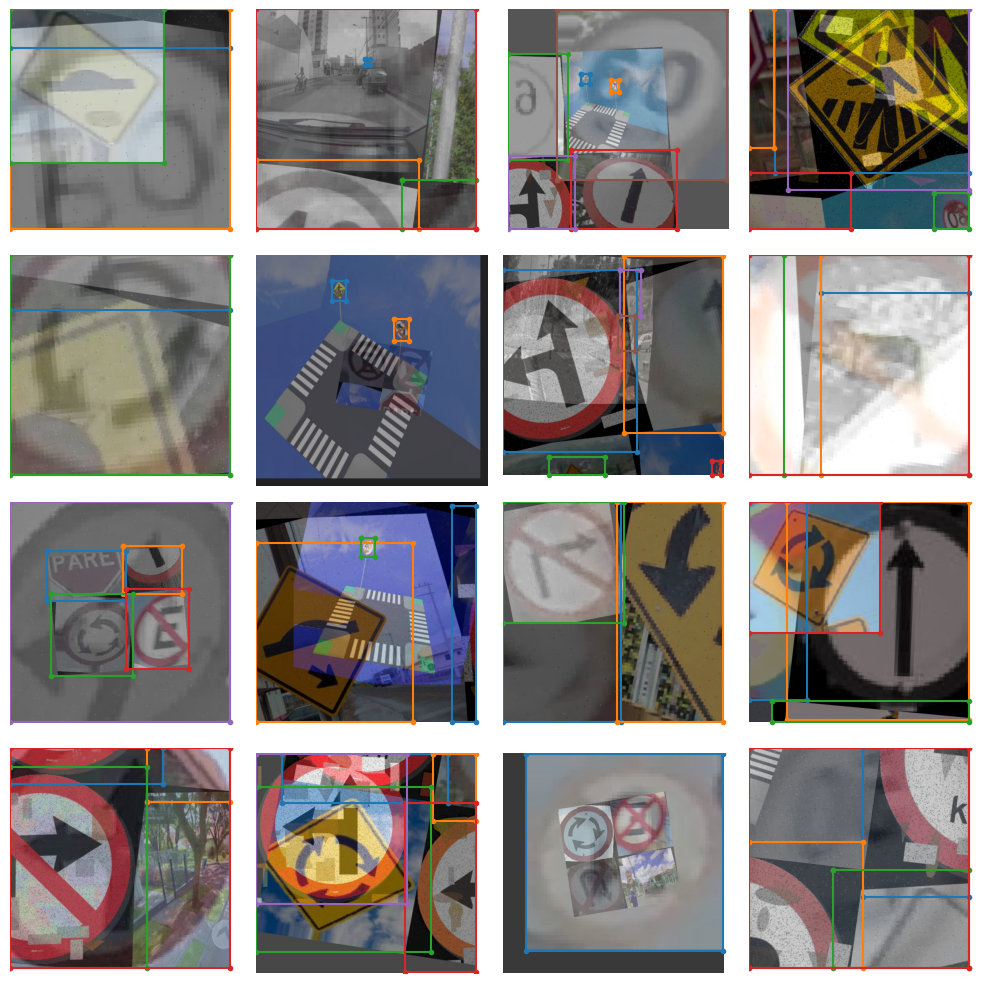

In [ ]:
train_data.dataset.plot()

**Configuramos el modelo a utilizar**

In [ ]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

[2024-06-03 03:14:12] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

**Configuramos los hyperparametros de entrenamiento**

max_epochs - numero maximo de epochs

loss - funcion de perdida a utilizar

optimizer - Optimizador a utilizar

train_metrics_list - Metricas para registrar durante el entrenamiento

valid_metrics_list - Metricas para registrar durante el entrenamiento

metric_to_watch - métrica según la cual se guardará el punto de control del modelo

In [ ]:
train_params = {
    # ENABLING SILENT MODE SET True if you want
    'silent_mode': False,
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

**Comenzamos el entrenamiento**

In [ ]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

The console stream is now moved to /checkpoints/placastransito/console_Jun03_03_14_19.txt


[2024-06-03 03:14:19] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2024-06-03 03:14:23] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 7400       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         925        (len(train_loader))
    - Gradient updates per epoch:   925        (len(train_loader) / batch_accumulate)

[2024-06-03 03:14:23] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validating: 100%|██████████| 88/88 [00:34<00:00,  2.56it/s]
[2024-06-03 03:27:51] INFO - base_sg_logger.py -

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.503
│   ├── Ppyoloeloss/loss_iou = 0.1248
│   ├── Ppyoloeloss/loss_dfl = 1.0956
│   └── Ppyoloeloss/loss = 3.3628
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.6225
    ├── Ppyoloeloss/loss_iou = 0.0502
    ├── Ppyoloeloss/loss_dfl = 0.8093
    ├── Ppyoloeloss/loss = 3.1526
    ├── Precision@0.50 = 0.0209
    ├── Recall@0.50 = 0.0796
    ├── Map@0.50 = 0.0484
    └── F1@0.50 = 0.0219



Validating epoch 1: 100%|██████████| 88/88 [00:34<00:00,  2.55it/s]
[2024-06-03 03:41:23] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/placastransito/ckpt_best.pth
[2024-06-03 03:41:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3902648687362671


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.472
│   │   ├── Epoch N-1      = 2.503  (↘ -1.031)
│   │   └── Best until now = 2.503  (↘ -1.031)
│   ├── Ppyoloeloss/loss_iou = 0.0976
│   │   ├── Epoch N-1      = 0.1248 (↘ -0.0272)
│   │   └── Best until now = 0.1248 (↘ -0.0272)
│   ├── Ppyoloeloss/loss_dfl = 0.9365
│   │   ├── Epoch N-1      = 1.0956 (↘ -0.1591)
│   │   └── Best until now = 1.0956 (↘ -0.1591)
│   └── Ppyoloeloss/loss = 2.1843
│       ├── Epoch N-1      = 3.3628 (↘ -1.1785)
│       └── Best until now = 3.3628 (↘ -1.1785)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2386
    │   ├── Epoch N-1      = 2.6225 (↘ -1.3838)
    │   └── Best until now = 2.6225 (↘ -1.3838)
    ├── Ppyoloeloss/loss_iou = 0.0457
    │   ├── Epoch N-1      = 0.0502 (↘ -0.0045)
    │   └── Best until now = 0.0502 (↘ -0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.8072
    │   ├── Epoch N-1      = 0.8093 (↘ -0.002)
    │   └── Best until now = 0.8093 (↘ -0.002)
    ├── Ppyoloeloss/loss = 

Validating epoch 2: 100%|██████████| 88/88 [00:34<00:00,  2.59it/s]
[2024-06-03 03:55:01] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/placastransito/ckpt_best.pth
[2024-06-03 03:55:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5687099099159241


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3657
│   │   ├── Epoch N-1      = 1.472  (↘ -0.1063)
│   │   └── Best until now = 1.472  (↘ -0.1063)
│   ├── Ppyoloeloss/loss_iou = 0.095
│   │   ├── Epoch N-1      = 0.0976 (↘ -0.0026)
│   │   └── Best until now = 0.0976 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.9155
│   │   ├── Epoch N-1      = 0.9365 (↘ -0.021)
│   │   └── Best until now = 0.9365 (↘ -0.021)
│   └── Ppyoloeloss/loss = 2.0609
│       ├── Epoch N-1      = 2.1843 (↘ -0.1234)
│       └── Best until now = 2.1843 (↘ -0.1234)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.11
    │   ├── Epoch N-1      = 1.2386 (↘ -0.1286)
    │   └── Best until now = 1.2386 (↘ -0.1286)
    ├── Ppyoloeloss/loss_iou = 0.051
    │   ├── Epoch N-1      = 0.0457 (↗ 0.0053)
    │   └── Best until now = 0.0457 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.8296
    │   ├── Epoch N-1      = 0.8072 (↗ 0.0224)
    │   └── Best until now = 0.8072 (↗ 0.0224)
    ├── Ppyoloeloss/loss = 1.652

Validating epoch 3: 100%|██████████| 88/88 [00:33<00:00,  2.59it/s]
[2024-06-03 04:08:55] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/placastransito/ckpt_best.pth
[2024-06-03 04:08:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6160053610801697


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3171
│   │   ├── Epoch N-1      = 1.3657 (↘ -0.0486)
│   │   └── Best until now = 1.3657 (↘ -0.0486)
│   ├── Ppyoloeloss/loss_iou = 0.0947
│   │   ├── Epoch N-1      = 0.095  (↘ -0.0003)
│   │   └── Best until now = 0.095  (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.9091
│   │   ├── Epoch N-1      = 0.9155 (↘ -0.0064)
│   │   └── Best until now = 0.9155 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 2.0084
│       ├── Epoch N-1      = 2.0609 (↘ -0.0526)
│       └── Best until now = 2.0609 (↘ -0.0526)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0583
    │   ├── Epoch N-1      = 1.11   (↘ -0.0517)
    │   └── Best until now = 1.11   (↘ -0.0517)
    ├── Ppyoloeloss/loss_iou = 0.0527
    │   ├── Epoch N-1      = 0.051  (↗ 0.0018)
    │   └── Best until now = 0.0457 (↗ 0.0071)
    ├── Ppyoloeloss/loss_dfl = 0.841
    │   ├── Epoch N-1      = 0.8296 (↗ 0.0113)
    │   └── Best until now = 0.8072 (↗ 0.0337)
    ├── Ppyoloeloss/loss = 

Validating epoch 4: 100%|██████████| 88/88 [00:34<00:00,  2.58it/s]
[2024-06-03 04:23:06] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/placastransito/ckpt_best.pth
[2024-06-03 04:23:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6904833316802979


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2408
│   │   ├── Epoch N-1      = 1.3171 (↘ -0.0763)
│   │   └── Best until now = 1.3171 (↘ -0.0763)
│   ├── Ppyoloeloss/loss_iou = 0.0889
│   │   ├── Epoch N-1      = 0.0947 (↘ -0.0057)
│   │   └── Best until now = 0.0947 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.8785
│   │   ├── Epoch N-1      = 0.9091 (↘ -0.0306)
│   │   └── Best until now = 0.9091 (↘ -0.0306)
│   └── Ppyoloeloss/loss = 1.9024
│       ├── Epoch N-1      = 2.0084 (↘ -0.106)
│       └── Best until now = 2.0084 (↘ -0.106)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9244
    │   ├── Epoch N-1      = 1.0583 (↘ -0.1338)
    │   └── Best until now = 1.0583 (↘ -0.1338)
    ├── Ppyoloeloss/loss_iou = 0.0522
    │   ├── Epoch N-1      = 0.0527 (↘ -0.0005)
    │   └── Best until now = 0.0457 (↗ 0.0066)
    ├── Ppyoloeloss/loss_dfl = 0.8292
    │   ├── Epoch N-1      = 0.841  (↘ -0.0117)
    │   └── Best until now = 0.8072 (↗ 0.022)
    ├── Ppyoloeloss/loss = 

Validating epoch 5: 100%|██████████| 88/88 [00:34<00:00,  2.56it/s]
[2024-06-03 04:37:28] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/placastransito/ckpt_best.pth
[2024-06-03 04:37:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.778032124042511


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1812
│   │   ├── Epoch N-1      = 1.2408 (↘ -0.0597)
│   │   └── Best until now = 1.2408 (↘ -0.0597)
│   ├── Ppyoloeloss/loss_iou = 0.0838
│   │   ├── Epoch N-1      = 0.0889 (↘ -0.0051)
│   │   └── Best until now = 0.0889 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.8578
│   │   ├── Epoch N-1      = 0.8785 (↘ -0.0207)
│   │   └── Best until now = 0.8785 (↘ -0.0207)
│   └── Ppyoloeloss/loss = 1.8196
│       ├── Epoch N-1      = 1.9024 (↘ -0.0828)
│       └── Best until now = 1.9024 (↘ -0.0828)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8287
    │   ├── Epoch N-1      = 0.9244 (↘ -0.0957)
    │   └── Best until now = 0.9244 (↘ -0.0957)
    ├── Ppyoloeloss/loss_iou = 0.0509
    │   ├── Epoch N-1      = 0.0522 (↘ -0.0013)
    │   └── Best until now = 0.0457 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.8235
    │   ├── Epoch N-1      = 0.8292 (↘ -0.0057)
    │   └── Best until now = 0.8072 (↗ 0.0163)
    ├── Ppyoloeloss/loss

Validating epoch 6: 100%|██████████| 88/88 [00:34<00:00,  2.54it/s]
[2024-06-03 04:52:33] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/placastransito/ckpt_best.pth
[2024-06-03 04:52:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7981775999069214


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1142
│   │   ├── Epoch N-1      = 1.1812 (↘ -0.067)
│   │   └── Best until now = 1.1812 (↘ -0.067)
│   ├── Ppyoloeloss/loss_iou = 0.0802
│   │   ├── Epoch N-1      = 0.0838 (↘ -0.0036)
│   │   └── Best until now = 0.0838 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.8354
│   │   ├── Epoch N-1      = 0.8578 (↘ -0.0224)
│   │   └── Best until now = 0.8578 (↘ -0.0224)
│   └── Ppyoloeloss/loss = 1.7325
│       ├── Epoch N-1      = 1.8196 (↘ -0.0872)
│       └── Best until now = 1.8196 (↘ -0.0872)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7646
    │   ├── Epoch N-1      = 0.8287 (↘ -0.0641)
    │   └── Best until now = 0.8287 (↘ -0.0641)
    ├── Ppyoloeloss/loss_iou = 0.0507
    │   ├── Epoch N-1      = 0.0509 (↘ -0.0002)
    │   └── Best until now = 0.0457 (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 0.8193
    │   ├── Epoch N-1      = 0.8235 (↘ -0.0041)
    │   └── Best until now = 0.8072 (↗ 0.0121)
    ├── Ppyoloeloss/loss =

Validating epoch 7: 100%|██████████| 88/88 [00:34<00:00,  2.58it/s]
[2024-06-03 05:07:22] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/placastransito/ckpt_best.pth
[2024-06-03 05:07:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8328883647918701


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0557
│   │   ├── Epoch N-1      = 1.1142 (↘ -0.0585)
│   │   └── Best until now = 1.1142 (↘ -0.0585)
│   ├── Ppyoloeloss/loss_iou = 0.0727
│   │   ├── Epoch N-1      = 0.0802 (↘ -0.0075)
│   │   └── Best until now = 0.0802 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.8067
│   │   ├── Epoch N-1      = 0.8354 (↘ -0.0287)
│   │   └── Best until now = 0.8354 (↘ -0.0287)
│   └── Ppyoloeloss/loss = 1.6409
│       ├── Epoch N-1      = 1.7325 (↘ -0.0916)
│       └── Best until now = 1.7325 (↘ -0.0916)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7312
    │   ├── Epoch N-1      = 0.7646 (↘ -0.0334)
    │   └── Best until now = 0.7646 (↘ -0.0334)
    ├── Ppyoloeloss/loss_iou = 0.0524
    │   ├── Epoch N-1      = 0.0507 (↗ 0.0017)
    │   └── Best until now = 0.0457 (↗ 0.0068)
    ├── Ppyoloeloss/loss_dfl = 0.8266
    │   ├── Epoch N-1      = 0.8193 (↗ 0.0073)
    │   └── Best until now = 0.8072 (↗ 0.0194)
    ├── Ppyoloeloss/loss =

Validating epoch 8: 100%|██████████| 88/88 [00:34<00:00,  2.55it/s]
[2024-06-03 05:21:47] INFO - base_sg_logger.py - Checkpoint saved in /checkpoints/placastransito/ckpt_best.pth
[2024-06-03 05:21:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.852534830570221


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9891
│   │   ├── Epoch N-1      = 1.0557 (↘ -0.0666)
│   │   └── Best until now = 1.0557 (↘ -0.0666)
│   ├── Ppyoloeloss/loss_iou = 0.0683
│   │   ├── Epoch N-1      = 0.0727 (↘ -0.0044)
│   │   └── Best until now = 0.0727 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.7851
│   │   ├── Epoch N-1      = 0.8067 (↘ -0.0216)
│   │   └── Best until now = 0.8067 (↘ -0.0216)
│   └── Ppyoloeloss/loss = 1.5524
│       ├── Epoch N-1      = 1.6409 (↘ -0.0885)
│       └── Best until now = 1.6409 (↘ -0.0885)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6077
    │   ├── Epoch N-1      = 0.7312 (↘ -0.1235)
    │   └── Best until now = 0.7312 (↘ -0.1235)
    ├── Ppyoloeloss/loss_iou = 0.0494
    │   ├── Epoch N-1      = 0.0524 (↘ -0.0031)
    │   └── Best until now = 0.0457 (↗ 0.0037)
    ├── Ppyoloeloss/loss_dfl = 0.8164
    │   ├── Epoch N-1      = 0.8266 (↘ -0.0102)
    │   └── Best until now = 0.8072 (↗ 0.0092)
    ├── Ppyoloeloss/loss

Validating epoch 9: 100%|██████████| 88/88 [00:34<00:00,  2.58it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9475
│   │   ├── Epoch N-1      = 0.9891 (↘ -0.0416)
│   │   └── Best until now = 0.9891 (↘ -0.0416)
│   ├── Ppyoloeloss/loss_iou = 0.0636
│   │   ├── Epoch N-1      = 0.0683 (↘ -0.0047)
│   │   └── Best until now = 0.0683 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.7666
│   │   ├── Epoch N-1      = 0.7851 (↘ -0.0184)
│   │   └── Best until now = 0.7851 (↘ -0.0184)
│   └── Ppyoloeloss/loss = 1.4897
│       ├── Epoch N-1      = 1.5524 (↘ -0.0627)
│       └── Best until now = 1.5524 (↘ -0.0627)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6686
    │   ├── Epoch N-1      = 0.6077 (↗ 0.0609)
    │   └── Best until now = 0.6077 (↗ 0.0609)
    ├── Ppyoloeloss/loss_iou = 0.0462
    │   ├── Epoch N-1      = 0.0494 (↘ -0.0032)
    │   └── Best until now = 0.0457 (↗ 0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.8038
    │   ├── Epoch N-1      = 0.8164 (↘ -0.0127)
    │   └── Best until now = 0.8072 (↘ -0.0035)
    ├── Ppyoloeloss/loss 

[2024-06-03 05:38:11] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 88/88 [00:41<00:00,  2.10it/s]


In [ ]:

best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/checkpoints/placastransito/ckpt_best.pth")
# checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

[2024-06-03 05:39:36] INFO - checkpoint_utils.py - Successfully loaded model weights from /checkpoints/placastransito/ckpt_best.pth EMA checkpoint.


In [ ]:
trainer.test(model=best_model,
             test_loader=test_data,
             test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                    top_k_predictions=300,
                                                    num_cls=len(
                                                        dataset_params['classes']),
                                                    normalize_targets=True,
                                                    post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                           nms_top_k=1000,
                                                                                                           max_predictions=300,
                                                                                                           nms_threshold=0.7)
                                                    ))

Testing: 100%|██████████| 41/41 [00:17<00:00,  2.57it/s]

{'PPYoloELoss/loss_cls': 0.67865753,
 'PPYoloELoss/loss_iou': 0.049851403,
 'PPYoloELoss/loss_dfl': 0.78672934,
 'PPYoloELoss/loss': 1.1966507,
 'Precision@0.50': 0.052727144211530685,
 'Recall@0.50': 0.9920635223388672,
 'mAP@0.50': 0.8571498990058899,
 'F1@0.50': 0.09990347921848297}

Testing: 100%|██████████| 41/41 [00:17<00:00,  2.34it/s]


**Losses:**

*loss_iou*: Evalúa la precisión con la que el modelo localiza los objetos.

*loss_dfl*: refleja la precisión de la localización de objetos.

*loss*: pérdida general que el modelo intenta minimizar durante el entrenamiento.

**Métricas de rendimiento**


*Precicion@0,50*: Porcentaje de casos positivos pronosticados correctamente.

*Recall@0. 50*: Porcentaje de casos positivos reales predichos correctamente.

*mAP@0. 50*: Precisión promedio media, una combinación de precisión y recuperación.

*F1@0. 50*: Media armónica de precisión y recuperación.

--------------------------------

**Ejecutar prueba con Link de imagen**

Predicting Images: 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


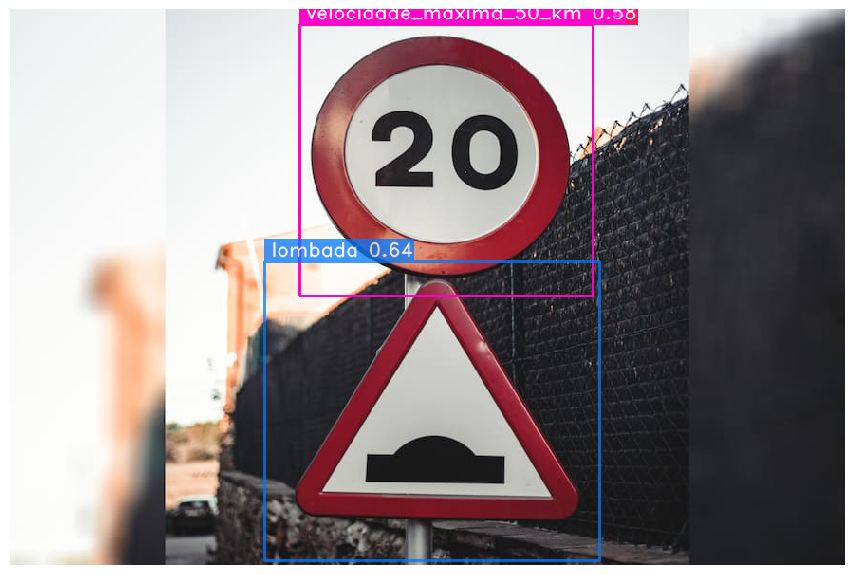

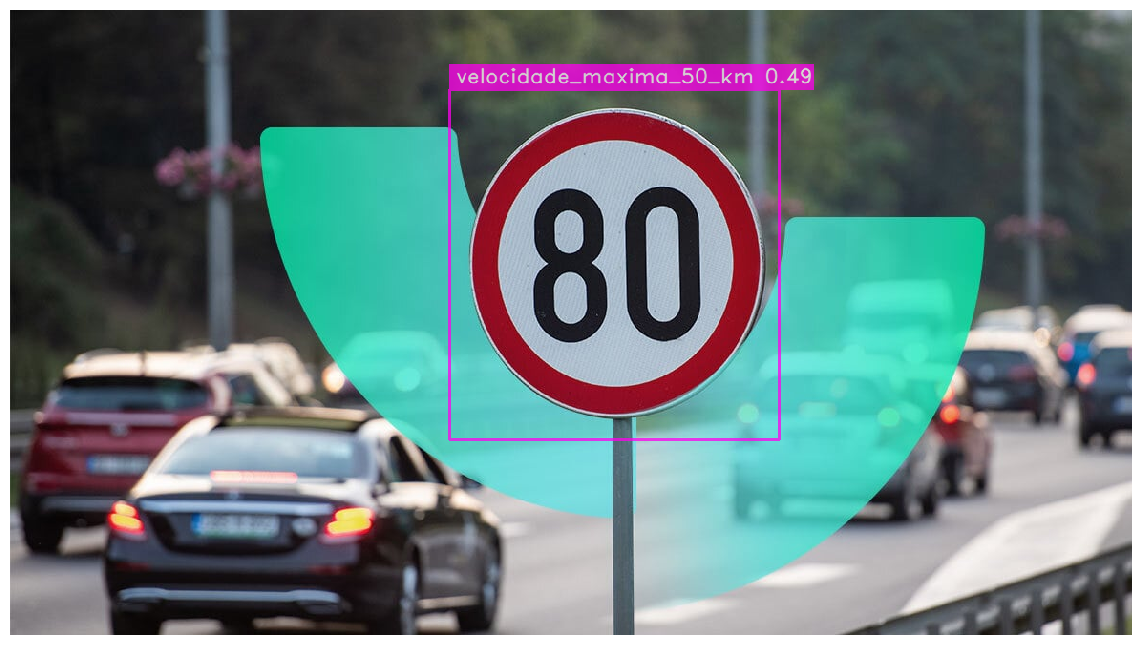

In [ ]:
Images = ['https://resizer.glanacion.com/resizer/v2/saber-identificar-las-senales-de-transito-es-NNEXZ6STKNCELDUTZZIBVBZRWA.jpg?auth=e4e1a1da1d7597d48abf5bc499dc381529f4fb108d54fefd380d2f345f5799f1&width=880&height=586&quality=70&smart=true',
          'https://www.grupor5.com/hubfs/senales-de-transito-reglamentarias-r5.jpg']


images_predications = best_model.predict(Images, iou=0.5, conf=0.4).show()



**Ejecutado prueba con video.**

In [ ]:
import torch
device = 0 if torch.cuda.is_available() else "cpu"

input_video_path = "ubicacion del video"
output_video_path = "detections_one.mp4"
# device=0

best_model.to(device).predict(input_video_path).save(output_video_path)

In [ ]:
!pip install onemetric supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path="/content/placasvwise-31/test/images",
    annotations_directory_path="/content/placasvwise-31/test/labels",
    data_yaml_path="/content/placasvwise-31/data.yaml",
    force_masks=False
)

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2024-06-03 06:05:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-03 06:05:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-03 06:05:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-03 06:05:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-03 06:05:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-03 06:05:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-03 06:05:38] INFO -

KeyboardInterrupt: 

In [ ]:
from google.colab import files

In [ ]:


!zip -r "/checkpoints/placastransito/frames.zip" "/checkpoints/placastransito"


  adding: checkpoints/placastransito/ (stored 0%)
  adding: checkpoints/placastransito/logs_Jun03_03_14_19.txt (deflated 86%)
  adding: checkpoints/placastransito/logs_Jun03_03_12_20.txt (deflated 85%)
  adding: checkpoints/placastransito/ckpt_best.pth (deflated 7%)
  adding: checkpoints/placastransito/experiment_logs_Jun03_03_14_19.txt (deflated 72%)
  adding: checkpoints/placastransito/events.out.tfevents.1717384268.7ab46bfae008.1626.0 (deflated 89%)
  adding: checkpoints/placastransito/events.out.tfevents.1717393135.7ab46bfae008.1626.4 (deflated 43%)
  adding: checkpoints/placastransito/console_Jun03_03_11_08.txt (deflated 81%)
  adding: checkpoints/placastransito/events.out.tfevents.1717384283.7ab46bfae008.1626.1 (deflated 41%)
  adding: checkpoints/placastransito/experiment_logs_Jun03_03_11_08.txt (deflated 73%)
  adding: checkpoints/placastransito/average_model.pth (deflated 7%)
  adding: checkpoints/placastransito/console_Jun03_03_14_19.txt (deflated 96%)
  adding: checkpoints/p